In [1]:
#import need libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

import nltk
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split
from numpy import array
from tensorflow import keras
from tensorflow.keras import regularizers, layers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

In [2]:
def clean_tweets(text):
    """
    This function takes tweets and prepares them for modeling
    """
    no_handle = tweet_tknzr.tokenize(text) # Tweet tokenizer removes Twitter mentions
    tweet = " ".join(no_handle) #bring tokens back 
    clean = re.sub("(https?:\/\/\S+) \
                   |(#[A-Za-z0-9_]+) \
                   |(\{([a-zA-Z].+)\}) \
                   |(&[a-z]+;) \
                   |(www\.[a-z]?\.?(com)+|[a-z]+\.(com))\
                   |(\[video\])\
                   |([^\x00-\x7F]+\ *(?:[^\x00-\x7F]| )*)"," ", tweet) #remove http websites, 
                                                                       #remove pound sign, 
                                                                       #removes brackets, #
                                                                       # any words with ampersand right in front
                                                                       # ?, www dot com websites, 
                                                                       #videos,
                                                                       #non english characters
    lower = clean.lower() 
    token_list = tokenizer.tokenize(lower)
    stopwords_removed=[token for token in token_list if token not in stopwords_list]
    lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
    cleaned_string = " ".join(lemma_list) #Turn the lemma list into a string for the Vectorizer
    return cleaned_string

In [3]:
def create_embedding_matrix(glove_filepath, word_index, embedding_dim):
    '''
    
    Grabs the embeddings just for the words in our vocabulary
    
    Inputs:
    glove_filepath - string, location of the glove text file to use
    word_index - word_index attribute from the keras tokenizer
    embedding_dim - int, number of dimensions to embed, a hyperparameter
    
    Output:
    embedding_matrix - numpy array of embeddings
    '''
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(glove_filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [4]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [5]:
#pull out pickled DataFrame
cleaned = pd.read_pickle("./cleaned.pkl")
cleaned

,Tweet,Product,Sentiment,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google
...,...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion,Google
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Apple
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion,Google
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion,Google


In [6]:
#Setting the target to a binary classification
dict_sent = {"No emotion":0, 
             "Positive emotion":1,
             "Negative emotion":0,
             "I can't tell": 0}
cleaned['Sentiment'] = cleaned['Sentiment'].map(dict_sent)

In [7]:
#percentage of Tweets by sentiment
cleaned["Sentiment"].value_counts()

0    6099
1    2970
Name: Sentiment, dtype: int64

In [8]:
#Sanity Check
cleaned.head()

,Tweet,Product,Sentiment,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,Google


In [9]:
#doing a test-train-split with a holdout set
X = cleaned[['Tweet']]
y = cleaned['Sentiment']
#holdout set
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
#training set
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

In [10]:
#Baseline
y_train.value_counts(normalize=True)

0    0.67636
1    0.32364
Name: Sentiment, dtype: float64

In [11]:
#Sanity Check
X_train.head()

,Tweet
2320,@mention Can we make you an iPhone case with T...
5622,RT @mention Come party down with @mention &amp...
1748,#winning #winning - just gave away 5 red mophi...
5789,RT @mention google &amp; facebook have an offi...
3334,Rumor of Google launching their new social net...


In [12]:
#looking at shape of Training Data
X_train.shape

(6121, 1)

In [13]:
#Lokking at shape of Testing Data
X_val.shape

(2041, 1)

In [14]:
#test tweet for cleaning
X_train["Tweet"].iloc[0]

'@mention Can we make you an iPhone case with TTYE on it just in time for #sxsw? We want to show our support!'

In [15]:
#Instantiate necessary tools
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")
stopwords_list = set(stopwords.words("english"))
extra = ["sxsw","link", "apple", "google"]
stopwords_list = stopwords_list.union(extra) #adds link to stop words
lemma = WordNetLemmatizer()
tweet_tknzr = TweetTokenizer(strip_handles=True)

In [16]:
#Sanity Check
clean_tweets(X_train["Tweet"].iloc[0])

'make iphone case ttye time want show support'

In [17]:
#Cleans the test and train sets
X_train['Tweet'] = X_train["Tweet"].apply(lambda x: clean_tweets(x))
X_val['Tweet'] = X_val["Tweet"].apply(lambda x: clean_tweets(x))

C:\Users\david\AppData\Local\Temp/ipykernel_59644/481070063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Tweet'] = X_train["Tweet"].apply(lambda x: clean_tweets(x))
C:\Users\david\AppData\Local\Temp/ipykernel_59644/481070063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['Tweet'] = X_val["Tweet"].apply(lambda x: clean_tweets(x))


In [18]:
X_train.shape

(6121, 1)

In [19]:
#Sanity Check
X_train.head()

,Tweet
2320,make iphone case ttye time want show support
5622,come party tonight band food art interactive map
1748,winning winning gave away red mophie juice pac...
5789,facebook official death policy vast majority d...
3334,rumor launching new social network called circ...


In [20]:
#Sanity Check
X_val.head()

,Tweet
888,hootsuite mobile update iphone blackberry andr...
4191,morning hearing circle today
2161,great location choice nice timing ipad launch ...
1882,win ipad via
4693,launching product plenty else join h4ckers 80 ...


In [21]:
#Sanity Check
y_train.head()

2320    0
5622    1
1748    0
5789    0
3334    0
Name: Sentiment, dtype: int64

In [22]:
#Sanity Check
y_val.head()

888     0
4191    0
2161    1
1882    1
4693    0
Name: Sentiment, dtype: int64

# Neural Network with GLoVE

In [23]:
# Sets the sets as a Series Object
X_train = X_train["Tweet"]
X_val = X_val["Tweet"]

In [24]:
print(type(X_train))
print(type(X_val))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [25]:
#How long is our longest tweet
max_length = max([len(tweet.split()) for tweet in X_train])
max_length

18

In [26]:
#Sanity Check
X_train.shape

(6121,)

In [27]:
# Instatiate the Tokenizer
k_tokenizer = keras.preprocessing.text.Tokenizer()

#fit the tokenizer
k_tokenizer.fit_on_texts(X_train)

#
X_train_token = k_tokenizer.texts_to_sequences(X_train)
X_val_token = k_tokenizer.texts_to_sequences(X_val)

In [28]:
#pads the tweets for equal length
X_train_processed = keras.preprocessing.sequence.pad_sequences(
    X_train_token, maxlen=max_length, padding='post')
X_val_processed = keras.preprocessing.sequence.pad_sequences(
    X_val_token, maxlen=max_length, padding='post')

In [29]:
X_train_processed.shape

(6121, 18)

In [30]:
#checks word length list
vocab_size = len(k_tokenizer.word_index) + 1
maxlen= 100
print(vocab_size)

7137


The following Fuction Can be found here : https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review

GloVE file to large for Git Hub, can be found here: https://nlp.stanford.edu/projects/glove/

In [32]:
#sets the embedding dimensions
embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt',
                                           k_tokenizer.word_index, 
                                           embedding_dim)

## Baseline Neural Network

This is sequential neural network only has an input and output layey to act as a baseline model.

In [33]:
#Instatiate Model
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, #adds initial embedded layer
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=True))
model.add(layers.Flatten()) # flattening these layers down before connecting to dense layer
model.add(layers.Dense(1, activation='sigmoid')) #defines output layer

model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 50)            356850    
_________________________________________________________________
flatten (Flatten)            (None, 900)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 901       
Total params: 357,751
Trainable params: 357,751
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(X_train_processed, y_train, 
                    batch_size=50, 
                    epochs=10, 
                    validation_data=(X_val_processed, y_val))

Epoch 1/10
123/123 [==============================] - 2s 16ms/step - loss: 0.6660 - accuracy: 0.6288 - val_loss: 0.6343 - val_accuracy: 0.6521
Epoch 2/10
123/123 [==============================] - 1s 11ms/step - loss: 0.5904 - accuracy: 0.6937 - val_loss: 0.6086 - val_accuracy: 0.6649
Epoch 3/10
123/123 [==============================] - 1s 10ms/step - loss: 0.5449 - accuracy: 0.7272 - val_loss: 0.5955 - val_accuracy: 0.6712
Epoch 4/10
123/123 [==============================] - 1s 11ms/step - loss: 0.4993 - accuracy: 0.7661 - val_loss: 0.5815 - val_accuracy: 0.6952
Epoch 5/10
123/123 [==============================] - 1s 10ms/step - loss: 0.4546 - accuracy: 0.7971 - val_loss: 0.5729 - val_accuracy: 0.6997
Epoch 6/10
123/123 [==============================] - 1s 10ms/step - loss: 0.4072 - accuracy: 0.8278 - val_loss: 0.5686 - val_accuracy: 0.7065
Epoch 7/10
123/123 [==============================] - 1s 11ms/step - loss: 0.3624 - accuracy: 0.8507 - val_loss: 0.5687 - val_accuracy: 0.7095

In [44]:
score = model.evaluate(X_val_processed, y_val, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.7259404063224792
Test accuracy: 0.7349338531494141


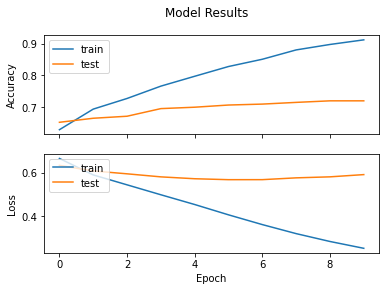

In [36]:
visualize_training_results(history)

This model is extremely overfitting, adding some hidden and Dropout layers to help with the previous overfitting.

In [48]:
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=True))
model.add(layers.Flatten()) # flattening these layers down before connecting to dense layer
model.add(Dropout(0.5))
model.add(layers.Dense(350, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(layers.Dense(350))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 18, 50)            356850    
_________________________________________________________________
flatten_2 (Flatten)          (None, 900)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 900)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 350)               315350    
_________________________________________________________________
dropout_3 (Dropout)          (None, 350)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 350)               122850    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [49]:
history = model.fit(X_train_processed, y_train, 
                    batch_size=50, 
                    epochs=10, 
                    validation_data=(X_val_processed, y_val))

Epoch 1/10
123/123 [==============================] - 2s 19ms/step - loss: 0.7207 - accuracy: 0.6296 - val_loss: 0.6100 - val_accuracy: 0.6644
Epoch 2/10
123/123 [==============================] - 2s 14ms/step - loss: 0.6450 - accuracy: 0.6486 - val_loss: 0.6205 - val_accuracy: 0.6624
Epoch 3/10
123/123 [==============================] - 2s 14ms/step - loss: 0.6097 - accuracy: 0.6767 - val_loss: 0.5886 - val_accuracy: 0.6737
Epoch 4/10
123/123 [==============================] - 2s 15ms/step - loss: 0.5940 - accuracy: 0.6911 - val_loss: 0.5799 - val_accuracy: 0.6796
Epoch 5/10
123/123 [==============================] - 2s 16ms/step - loss: 0.5550 - accuracy: 0.7183 - val_loss: 0.5709 - val_accuracy: 0.6977
Epoch 6/10
123/123 [==============================] - 2s 18ms/step - loss: 0.5266 - accuracy: 0.7401 - val_loss: 0.5587 - val_accuracy: 0.7060
Epoch 7/10
123/123 [==============================] - 2s 16ms/step - loss: 0.4995 - accuracy: 0.7499 - val_loss: 0.5897 - val_accuracy: 0.6933

In [50]:
score = model.evaluate(X_val_processed, y_val, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5513203740119934
Test accuracy: 0.7270945906639099


Following Function can be found here : https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review

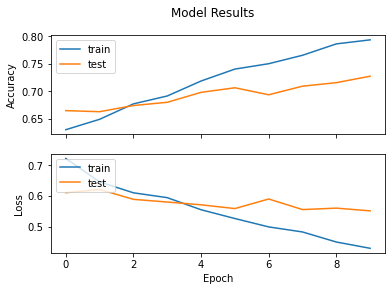

In [51]:
visualize_training_results(history)

The model is performing better, but is still over fitting. Next we will add some regularization to model to solve the overfittiing.

# Nueral Network with Regularization

In [40]:
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=True))
model.add(layers.Flatten()) # flattening these layers down before connecting to dense layer
model.add(Dropout(0.5))
model.add(layers.Dense(350, activation='sigmoid',
                       kernel_regularizer=regularizers.l2(l2=1e-3),
                       bias_regularizer=regularizers.l2(1e-3),
                      activity_regularizer=regularizers.l2(1e-3)))
model.add(Dropout(0.5))
model.add(layers.Dense(350, activation='sigmoid',
                       kernel_regularizer=regularizers.l2(l2=1e-3),
                       bias_regularizer=regularizers.l2(1e-3),
                      activity_regularizer=regularizers.l2(1e-3)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 18, 50)            356850    
_________________________________________________________________
flatten_1 (Flatten)          (None, 900)               0         
_________________________________________________________________
dropout (Dropout)            (None, 900)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 350)               315350    
_________________________________________________________________
dropout_1 (Dropout)          (None, 350)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 350)               122850    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [41]:
history = model.fit(X_train_processed, y_train, 
                    batch_size=50, 
                    epochs=20, 
                    validation_data=(X_val_processed, y_val))

Epoch 1/20
123/123 [==============================] - 3s 21ms/step - loss: 1.1544 - accuracy: 0.6692 - val_loss: 0.9117 - val_accuracy: 0.6619
Epoch 2/20
123/123 [==============================] - 2s 16ms/step - loss: 0.8459 - accuracy: 0.6777 - val_loss: 0.7936 - val_accuracy: 0.6634
Epoch 3/20
123/123 [==============================] - 2s 16ms/step - loss: 0.7636 - accuracy: 0.6844 - val_loss: 0.7616 - val_accuracy: 0.6850
Epoch 4/20
123/123 [==============================] - 2s 16ms/step - loss: 0.7197 - accuracy: 0.7040 - val_loss: 0.7156 - val_accuracy: 0.6908
Epoch 5/20
123/123 [==============================] - 2s 15ms/step - loss: 0.6923 - accuracy: 0.7174 - val_loss: 0.7076 - val_accuracy: 0.6952
Epoch 6/20
123/123 [==============================] - 2s 16ms/step - loss: 0.6691 - accuracy: 0.7417 - val_loss: 0.6927 - val_accuracy: 0.7109
Epoch 7/20
123/123 [==============================] - 2s 15ms/step - loss: 0.6519 - accuracy: 0.7527 - val_loss: 0.7118 - val_accuracy: 0.6957

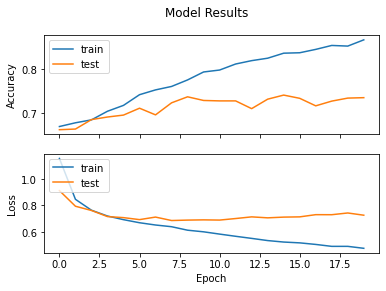

In [42]:
visualize_training_results(history)